# 목적
- 최근 몇 년간 지속된 저금리기조로 정기예금 금리가 낮은 편이다. 
- 정기예금금리에 대하여, 이자소득세와 물가상승율을 고려한 **실질금리**의 추세를 살펴보자.
- 고려사항
    - 기간: 1996년 ~ 2020년 1월(최근)
    - 상품: **1년**만기 정기예금
    - 기간 중 이자소득세 변동 내역을 반영한다.
- 데이터
    - 정기예금금리 데이터 [한국은행 경제통계시스템 4.2.1.1 신규취급액 기준](http://ecos.bok.or.kr/flex/EasySearch.jsp)
    - 소비자물가지수 데이터 [한국은행 경제통계시스템 7.4.1 소비자물가지수(2015=100)](http://ecos.bok.or.kr/flex/EasySearch.jsp)
    - 국내 이자소득세율 변화 이력 [pinterest 검색](https://www.pinterest.co.kr/jaystrange/insurance/)

In [2]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import Image
from IPython.display import display, HTML

In [4]:
물가 = pd.read_csv('./data/소비자물가지수.csv', engine='python', 
                 header=None, skiprows=5, index_col=0, parse_dates=True, encoding='euc-kr')
물가.index.name = '일시'
물가.rename(columns={1: '소비자물가지수'}, inplace=True)
물가['물가상승율'] = np.round(물가['소비자물가지수'].pct_change(12) * 100, 2)

In [5]:
물가[:15]

,소비자물가지수,물가상승율
일시,,
1965-01-01,2.628,NaN
1965-02-01,2.686,NaN
1965-03-01,2.691,NaN
1965-04-01,2.733,NaN
1965-05-01,2.788,NaN
1965-06-01,2.763,NaN
1965-07-01,2.798,NaN
1965-08-01,2.827,NaN
1965-09-01,2.813,NaN


In [6]:
예금 = pd.read_csv('./data01/정기예금금리.csv', 
                 engine='python', header=None, skiprows=4, 
                 index_col=0, parse_dates=True, encoding='euc-kr')
예금 = 예금[6]
예금 = DataFrame(예금)
예금.index.name = '일시'
예금.rename(columns={6: '예금금리(세전)'}, inplace=True)
예금.dropna(how='all', inplace=True)

In [10]:
예금.head()

,예금금리(세전)
일시,
1996-07-01,9.83
1996-08-01,10.26
1996-09-01,10.31
1996-10-01,10.38
1996-11-01,9.78


## 이자소득세율 이력

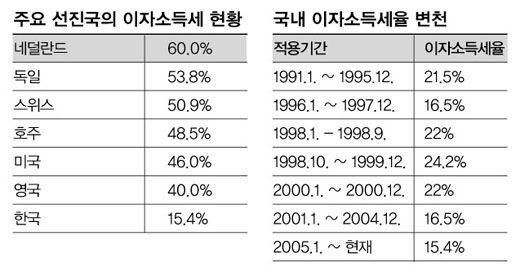

In [6]:
Image(filename='이자소득세율_변화.jpg')

## 이자소득세율을 구하기 위한 함수

In [7]:
def get_ts(start, end, interest):
    return Series(interest, index=pd.date_range(start - timedelta(1), end, freq='M') + timedelta(1))

In [8]:
기간_이자소득세 = {
    (datetime(1991,1,1), datetime(1995,12,1)): 0.215,
    (datetime(1996,1,1), datetime(1997,12,1)): 0.165,
    (datetime(1998,1,1), datetime(1998,9,1)): 0.22,
    (datetime(1998,10,1), datetime(1999,12,1)): 0.242,
    (datetime(2000,1,1), datetime(2000,12,1)): 0.22,
    (datetime(2001,1,1), datetime(2004,12,1)): 0.165,
    (datetime(2005,1,1), datetime(2020,3,1)): 0.154,
}

In [9]:
result = []
for date, interest in 기간_이자소득세.items():
    result.append(get_ts(date[0], date[1], interest))
이자소득세 = DataFrame(pd.concat(result, axis=0))
이자소득세.rename(columns={0: '이자소득세'}, inplace=True)

In [10]:
이자소득세.head()

,이자소득세
1991-01-01,0.215
1991-02-01,0.215
1991-03-01,0.215
1991-04-01,0.215
1991-05-01,0.215


## 물가, 예금, 이자소득세를 하나의 DataFrame으로 통합

In [11]:
df= pd.merge(pd.merge(물가, 예금, left_index=True, right_index=True),
             이자소득세, left_index=True, right_index=True)

In [12]:
df.head()

,소비자물가지수,물가상승율,예금금리(세전),이자소득세
1996-07-01,57.766,5.40,9.83,0.165
1996-08-01,58.039,5.27,10.26,0.165
1996-09-01,58.150,4.53,10.31,0.165
1996-10-01,58.150,5.05,10.38,0.165
1996-11-01,58.150,5.26,9.78,0.165


## 이자소득세를 고려한 세후예금금리

In [13]:
df['예금금리(세후)'] = np.round(df['예금금리(세전)'] * (1 - df['이자소득세']), 2)

In [14]:
df.head()

,소비자물가지수,물가상승율,예금금리(세전),이자소득세,예금금리(세후)
1996-07-01,57.766,5.40,9.83,0.165,8.21
1996-08-01,58.039,5.27,10.26,0.165,8.57
1996-09-01,58.150,4.53,10.31,0.165,8.61
1996-10-01,58.150,5.05,10.38,0.165,8.67
1996-11-01,58.150,5.26,9.78,0.165,8.17


## 물가상승율을 고려한 실질예금금리

In [15]:
df['실질금리'] = df['예금금리(세후)'] - df['물가상승율']

In [16]:
df.head()

,소비자물가지수,물가상승율,예금금리(세전),이자소득세,예금금리(세후),실질금리
1996-07-01,57.766,5.40,9.83,0.165,8.21,2.81
1996-08-01,58.039,5.27,10.26,0.165,8.57,3.30
1996-09-01,58.150,4.53,10.31,0.165,8.61,4.08
1996-10-01,58.150,5.05,10.38,0.165,8.67,3.62
1996-11-01,58.150,5.26,9.78,0.165,8.17,2.91


## 주요 이벤트들

In [17]:
crisis_data = [
    (datetime(1997, 12, 3), 'IMF 구제금융'),
    (datetime(2008, 9, 15), '리먼브라더스 파산'),
    (datetime(2020, 1, 22), '코로나바이러스 확산')
]

C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


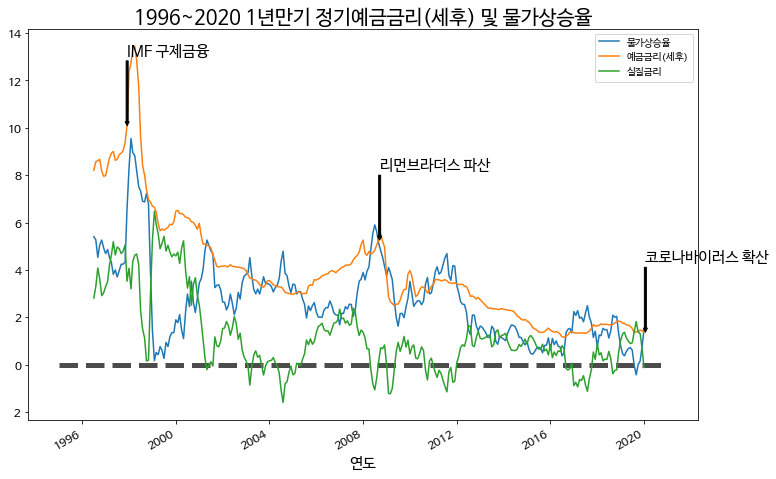

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot((datetime(1995,1,1), datetime(2021, 1,1)), (0, 0), color='black', linestyle='--', linewidth=5, alpha=0.7)
df[['물가상승율', '예금금리(세후)', '실질금리']].plot(kind='line', ax=ax)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('연도', fontsize=15)
title = '1996~2020 1년만기 정기예금금리(세후) 및 물가상승율'
plt.title(title, fontsize=20)
for date, label in crisis_data:
    ax.annotate(label, xy=(date, df['예금금리(세후)'].asof(date)),
                xytext=(date, df['예금금리(세후)'].asof(date) + 3.5),
                arrowprops=dict(facecolor='black', headwidth=4, width=2,
                                headlength=4),
                horizontalalignment='left',
                verticalalignment='top',
                fontsize=15)
plt.show()

# 결론
## 2009년 금융위기 이후 2020년(현재)까지:
- 실질금리는 2% 이하이며,
- 실질금리가 마이너스인 구간도 다수 있음

In [19]:
df[df['실질금리'] < 0]

,소비자물가지수,물가상승율,예금금리(세전),이자소득세,예금금리(세후),실질금리
2001-05-01,69.234,5.26,6.05,0.165,5.05,-0.21
2001-06-01,69.434,5.03,6.00,0.165,5.01,-0.02
2001-08-01,69.833,4.69,5.54,0.165,4.63,-0.06
2003-02-01,72.962,3.89,4.56,0.165,3.81,-0.08
2003-03-01,73.828,4.52,4.37,0.165,3.65,-0.87
2003-04-01,73.695,3.75,4.37,0.165,3.65,-0.10
2003-09-01,74.294,3.33,3.96,0.165,3.31,-0.02
2003-10-01,74.360,3.71,3.92,0.165,3.27,-0.44
2003-11-01,74.227,3.43,4.04,0.165,3.37,-0.06
2004-05-01,76.025,3.35,3.95,0.165,3.30,-0.05


# 결과를 파일로 추출

In [20]:
title = '1996~2020 1년만기 정기예금금리(세후) 및 물가상승율'
df.to_excel(title + '.xlsx')
plt.savefig(title + '.png')

<Figure size 432x288 with 0 Axes>